In [1]:
import csv
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
path="data/starlink/"

R=6371
lat=110.95
long=111.314

constellation="starlink"
node_num=1584
cycle=100
single_upbound=30000
constellations=["starlink","kuiper","oneweb","iridium"]
gs_type = "distributed"
label = "distributed"

# total_ue=7568902783
# ratio=10000/total_ue
policy="P_OPT"  

In [3]:
ue_access_file=path+constellation+"_ue_access_"+policy+".npy"
ue_access=np.array(np.load(ue_access_file,allow_pickle=True))
print(type(ue_access[0][0]))
print(np.shape(ue_access))

<class 'numpy.int64'>
(10000, 100)


In [4]:
old_end_sp=np.array(np.load(path+gs_type+"_"+"old-end"+"_SP_delay_hop.npy",allow_pickle=True))  # access sat of gs
print(np.shape(old_end_sp))
old_new_sp=np.array(np.load(path+gs_type+"_"+"old-new"+"_SP_delay_hop.npy",allow_pickle=True))  # access sat of gs
print(np.shape(old_new_sp))
new_end_sp=np.array(np.load(path+gs_type+"_"+"new-end"+"_SP_delay_hop.npy",allow_pickle=True))  # access sat of gs
broadcast=np.array(np.load("data/skycore_broadcast_SP_delay_hop.npy",allow_pickle=True))
print(np.shape(new_end_sp))
print(new_end_sp[0][0])
print(int(new_end_sp[0][0][0]))

(10000, 99, 5)
(10000, 99, 5)
(10000, 99, 5)
[31 1549 9.066617069914704 3 list(["'31'", "'9'", "'1571'", "'1549'"])]
31


In [5]:
def cal_handover():
    r=[]
    for t in range(1,cycle):
        r_in=[]
        for i in range( len(ue_access)):
            if ue_access[i][t-1] != ue_access[i][t]:
                r_in.append(i)
        r.append(r_in)
    return r
ho=cal_handover()
print(np.shape(ho))
print(ho[0])

(99,)
[3873, 3945, 3975, 3995, 4007, 4092, 4120, 4155, 4220, 4250, 4322, 4406, 4867, 4878, 4893, 4903, 4966, 5043, 5049, 5062, 5066, 5077, 5098, 5705, 5707, 5732, 5735, 5743, 5751, 5801, 5817, 5864, 5866, 5917, 7440, 8313, 8330, 8363, 8565, 8579, 8583, 8597, 8653, 8667, 8668, 8674, 8684, 8687, 8688, 8693, 8700, 9174, 9222, 9378, 9383, 9413, 9475, 9481, 9485, 9490, 9499, 9500, 9649, 9776, 9874, 9875, 9876, 9877, 9880, 9881, 9882, 9902]


C:\Users\DELL\AppData\Roaming\Python\Python36\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [6]:
ratio=np.array(np.load("data/"+constellation+"_per_user_ratio"+str(single_upbound)+".npy",allow_pickle=True))
print(np.shape(ratio))

(100, 1584)


In [7]:
ratio_user=[]
for mins in range(cycle):
    user_t=[]
    for user in range(len(ue_access)):
        cur_sat=ue_access[user][mins]
        r=ratio[mins][cur_sat-1]
        user_t.append(r)
    ratio_user.append(user_t)
print(np.shape(ratio_user))
        

(100, 10000)


In [8]:
#5 Scenarios: spacecore ntn skycore dpcm tiansuan
# mobility_direct=[19+21+20,19,121+52+13+19+30+19+20,121+52+13+19,121+52+13+19]
# session_direct=[21+15,15,77+53+21+15,77+53+21+15,77+53+21+15]
mobility_core=[[0,0],[17,0],[0,0],[7,1],[7,1]]
mobility_inter=[1,23,16,1,111]
session_core=[0,3,0,0,0]

state_session=[]
def cal_leakage(ho,s_index):
    leakage=[]
    for t in range(cycle):
        tmp_leak=[0]*node_num
        if t%2==0:
            for ue in range(len(ue_access)):
                for sat in new_end_sp[ue][t][4][1:-1]:
                    sat=int(sat.strip('\''))-1
                    tmp_leak[sat]+=(ratio_user[t][ue]*session_core[s_index])
        if t==0:
            continue
        else:
            tmp_t=t-1
            for user in ho[tmp_t]:
                for sat in new_end_sp[user][tmp_t][4]:
                    sat=int(sat.strip('\''))-1
                    tmp_leak[sat]+=(ratio_user[t][user]*mobility_core[s_index][0])
                for sat in old_end_sp[user][tmp_t][4]:
                    sat=int(sat.strip('\''))-1
                    tmp_leak[sat]+=(ratio_user[t][user]*mobility_core[s_index][1])
                for sat in old_new_sp[user][tmp_t][4]:
                    sat=int(sat.strip('\''))-1
                    tmp_leak[sat]+=(ratio_user[t][user]*mobility_inter[s_index])
                if s_index==2:
                    pass_sat=[]
                    for sat_list in broadcast[user][tmp_t][4]:
                        for sat in sat_list:
                            sat=int(sat.strip('\''))-1
                            if sat not in pass_sat:
                                tmp_leak[sat]+=(ratio_user[t][user]*96)
                                pass_sat.append(sat)
        leakage.append(tmp_leak)
    print(np.shape(leakage))
    return leakage
name_s=['SpaceCore','NTN','SkyCore','DPCM','Tiansuan']
starlink_leakage=[]
for s_index in range(len(name_s)):
    starlink_leakage.append(cal_leakage(ho,s_index))


(99, 1584)
(99, 1584)
(99, 1584)
(99, 1584)
(99, 1584)


[169.85576886287114, 26556.4167198075, 62701.815442301806, 8900.68456375625, 27584.819138672075]


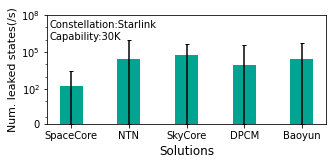

In [9]:
fig=plt.figure(figsize=(5,2))
locations=[5,10,15,20,25]
color=["#00A491","#F6C845"]
width=2
name_s=['SpaceCore','NTN','SkyCore','DPCM','Baoyun']
mean=[]
y1=[]
y2=[]
for s_index in range(len(name_s)):
    mean.append(np.mean(starlink_leakage[s_index])/60)
    t_max=np.max(starlink_leakage[s_index])/60
    t_min=np.min(starlink_leakage[s_index])/60
    y1.append(mean[-1]-t_min)
    y2.append(t_max-mean[-1])
print(mean)
plt.bar(locations,mean,yerr=[y1,y2],color=color[0],capsize=2,width=width)
plt.ylim([0,1e8])
plt.yscale("symlog")
plt.yticks([0,1e2,1e5,1e8],[0,'$ \mathit{10}^{2}$','$ \mathit{10}^{5}$','$ \mathit{10}^{8}$'])
plt.xticks(locations,name_s)
plt.xlabel("Solutions",fontsize=12)
plt.text(3.1,1e7,"Constellation:Starlink",fontsize=10)
plt.text(3.1,1e6,"Capability:30K",fontsize=10)
plt.ylabel("Num. leaked states(/s)",fontsize=11)
plt.savefig("figure19b.jpg",bbox_inches='tight')